In [1]:
# Install necessary requirements
# !pip install -r requirements


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import random
import numpy as np
import cv2
import joblib
import helper_module
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50, VGG19, MobileNetV3Large, EfficientNetV2S, MobileNetV3Small,Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split



2023-09-22 23:24:08.392244: I tensorflow/compiler/xla/stream_executor/tpu/tpu_initializer_helper.cc:269] Libtpu path is: libtpu.so
D0922 23:24:14.000344927   19508 config.cc:112]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0922 23:24:14.000373391   19508 config.cc:112]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0922 23:24:14.000378492   19508 config.cc:112]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0922 23:24:14.000383088   19508 config.cc:112]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0922 23:24:14.000387342   19508 config.cc:112]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0922 23:24:14.000391636   19508 config.cc:112]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0922 23:24:14.000395881

Check if TPU is available

In [3]:
# Check if a TPU is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    file_path = 'train_valid_dataset.joblib'
    print("TPU detected and initialized.")
except ValueError:
    # No TPU found, specify GPU or CPU here
    use_gpu = True  # Set this to True to use GPU or False to use CPU
    if use_gpu and tf.config.list_physical_devices("GPU"):
        strategy = tf.distribute.MirroredStrategy()  # Use GPU
        file_path = 'F:/cv_data/train_valid_dataset.joblib'
        print("Using GPU for TensorFlow computations.")
    else:
        strategy = tf.distribute.get_strategy()  # Use CPU
        file_path = 'F:/cv_data/train_valid_dataset.joblib'
        print("Using CPU for TensorFlow computations.")

# Now you can define and run your TensorFlow model using the selected strategy

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2023-09-22 23:25:08.744892: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5642e3e06d80 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2023-09-22 23:25:08.744934: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): TPU, 2a886c8
2023-09-22 23:25:08.744946: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): TPU, 2a886c8
2023-09-22 23:25:08.744956: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): TPU, 2a886c8
2023-09-22 23:25:08.744965: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): TPU, 2a886c8
2023-09-22 23:25:08.744975: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (4): TPU, 2a886c8
2023-09-22 23:25:08.744984: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (5): TPU, 2a886c8
2023-09-22 23:25:08.744994: I tensorflow/compiler/xla/service/service.cc:176]   StreamEx

INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

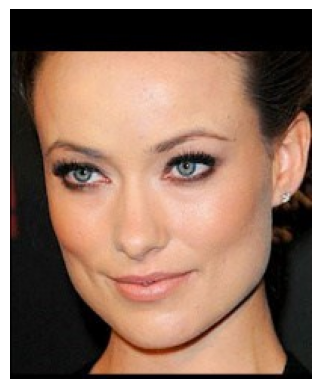

In [4]:
helper_module.show_img('dataset/train/left/abn.jpg')
train_pairing_df =helper_module.read_csv_to_df('dataset/train.csv')
test_candidates_df = helper_module.read_csv_to_df('dataset/test_candidates.csv')
archive_images_df = helper_module.read_csv_to_df('archive/votes.csv')

1.  Load Training data and augment it
2.  Load Testing data

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale pixel values to [0, 1]
    rotation_range=0,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift image width by up to 20%
    height_shift_range=0.2, # Randomly shift image height by up to 20%
    shear_range=0.2,        # Shear transformations
    zoom_range=0.0,         # Randomly zoom in on images by up to 20%
    horizontal_flip=False,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill mode for newly created pixels
)


Now Pair up the left and right images 
1. The  Data format will be  [Left,[Right1, Right2 ....]] In here the Right1 will be the similar image


In [6]:
def load_and_preprocess_image(image_path, target_size=(224,224), random_transform=False):
    # Open the image using Pillow (PIL)
    img = load_img(image_path, target_size=target_size)

    img = img.resize(target_size)

    img = img_to_array(img, dtype='uint8')


    if random_transform:
        img = train_datagen.random_transform(img)

    return img

def create_train_valid_dataset(random_transform, num_right_images=20):
    # Create a list to store the dataset
    dataset = []

    # Iterate through the rows of the CSV file and load/preprocess the images
    for index, row in train_pairing_df.iterrows():
        left_image = load_and_preprocess_image(f"dataset/train/left/{row['left']}.jpg", random_transform=random_transform)

        # Load and preprocess similar image
        similar_image = load_and_preprocess_image(f"dataset/train/right/{row['right']}.jpg", random_transform=random_transform)

        # Load and preprocess additional dissimilar images
        right_images = [similar_image] # put similar image at index 0

        for i in range(num_right_images-1):
            right_idx = random.randint(0, len(train_pairing_df) - 1)

            # Ensure the right right image is different from the similar image
            while right_idx == index:
                right_idx = random.randint(0, len(train_pairing_df) - 1)

            right_image = load_and_preprocess_image(f"dataset/train/right/{train_pairing_df.iloc[right_idx]['right']}.jpg", random_transform=random_transform)
            right_images.append(right_image)

        # Create a data entry containing the left image, list of right images, and the index of the similar image
        data_entry = [left_image, right_images]
        dataset.append(data_entry)

    return dataset

def create_train_valid_dataset_archive(random_transform, num_right_images=20):
    # Create lists to store paired left and right images
    image_pairs_with_label = []

    # Define the directory path where your images are located
    left_image_directory = 'archive/left/left/'  # Update with the correct directory path
    right_image_directory = 'archive/right/right/'  # Update with the correct directory path

    # Define the range for generating random indices
    min_idx = 1
    max_idx = 6015

    # Iterate through the rows of the CSV file and load/preprocess the images
    for index, row in archive_images_df.iterrows():
        # Generate the filename based on the index (e.g., '00000.jpg', '00001.jpg', etc.)
        image_filename = f"{index + 1:05d}.jpg"

        # Construct the full paths to the left and right images
        left_image_path = os.path.join(left_image_directory, image_filename)
        right_image_path = os.path.join(right_image_directory, image_filename)

        # Check if both image files exist
        if os.path.exists(left_image_path) and os.path.exists(right_image_path) and row['wins']>row['fails']:
            # Load and preprocess the left image
            left_image = load_and_preprocess_image(left_image_path, random_transform=random_transform)

            # Load and preprocess the right image
            right_image = load_and_preprocess_image(right_image_path, random_transform=random_transform)

            # Create a pair with left image and a list of right images
            image_pair_with_label = [left_image, [right_image]]

            # Add random dissimilar right images to the list
            for _ in range(num_right_images - 1):  # Subtract 1 to account for the similar right image
                random_idx = random.randint(min_idx, max_idx)
                while random_idx == index + 1:  # Ensure the dissimilar image is not the same as the left image
                    random_idx = random.randint(min_idx, max_idx)
                dissimilar_image_filename = f"{random_idx:05d}.jpg"
                dissimilar_image_path = os.path.join(right_image_directory, dissimilar_image_filename)
                dissimilar_image = load_and_preprocess_image(dissimilar_image_path, random_transform=random_transform)
                image_pair_with_label[1].append(dissimilar_image)

            image_pairs_with_label.append(image_pair_with_label)
        else:
            print(f"Image files not found for index {index + 1}: {left_image_path}, {right_image_path}")


    return image_pairs_with_label


Pair up images with similar and dissimilar
Show examples

Loaded dataset size is 7445
(224, 224, 3)


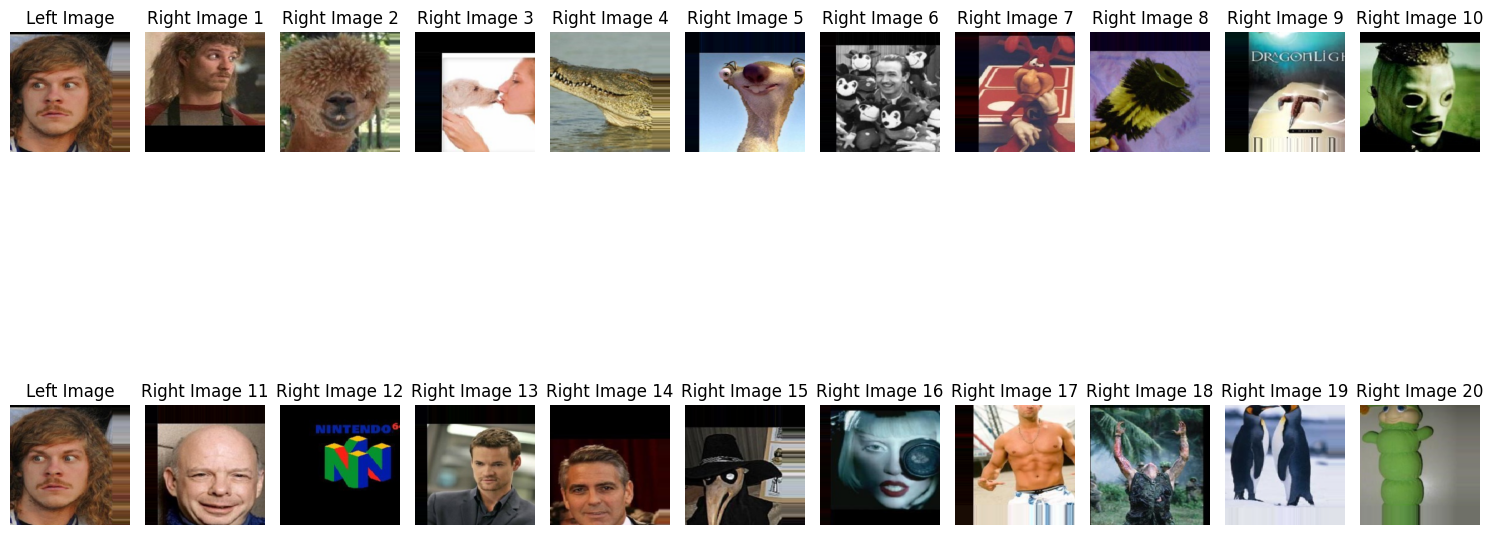

In [8]:
# Define a function to create and save the dataset if loading fails
def create_and_save_combined_dataset(file_path):
    train_valid_offical_dataset = create_train_valid_dataset(True, 20)
    train_valid_outside_dataset = create_train_valid_dataset_archive(True, 20)
    train_valid_dataset = train_valid_offical_dataset + train_valid_outside_dataset

    # Save data
    joblib.dump(train_valid_dataset, file_path)

# Try to load the dataset
try:
    train_valid_dataset = joblib.load(file_path)
    print(f"Loaded dataset size is {len(train_valid_dataset)}")
except FileNotFoundError:
    print("Dataset not found, creating and saving...")
    create_and_save_combined_dataset(file_path)
    train_valid_dataset = joblib.load(file_path)
    print(f"Created and saved dataset size is {len(train_valid_dataset)}")

# Now you have the dataset loaded or created, and you can work with it as needed.
print(train_valid_dataset[6000][0].shape)
helper_module.display_image_pair(train_valid_dataset[6000])

Now extract features using libraries. Such as local features

Show some local feautres and match features

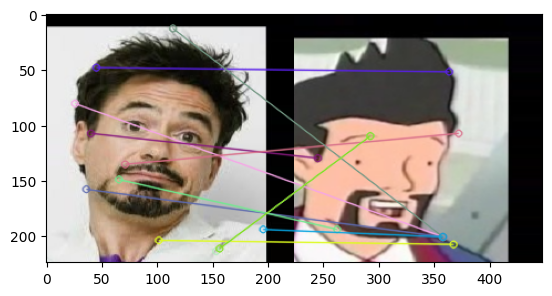

In [9]:
orb = cv2.ORB_create()
sift = cv2.SIFT_create()

# show_local_features(sift,train_valid_dataset[5][0][0])
helper_module.draw_image_matches(sift, [train_valid_dataset[5][0],train_valid_dataset[5][1][0]])

Create model

In [10]:
def create_siamese_with_model(input_shape, base_model, unfreeze_layer=False, num_right_inputs=1):
   
    input_left = tf.keras.layers.Input(shape=input_shape, name="left_input")
    input_right_list = tf.keras.layers.Input(shape=(num_right_inputs,) + input_shape, name="right_input")

    
    # Split and reshape the right input images
    split_right_inputs = Lambda(lambda x: [tf.squeeze(split, axis=1) for split in tf.split(x, num_or_size_splits=num_right_inputs, axis=1)])(input_right_list)
    
    embedding = create_embedding_model(input_shape, base_model,unfreeze_layer)

    output_left = embedding(input_left)
    output_right_list = [embedding(right_input) for right_input in split_right_inputs]

    # Calculate similarity scores (cosine similarity)
    raw_similarity_scores = [layers.Dot(axes=-1, normalize=True)([output_left, right]) for right in output_right_list]
    
    # Convert raw similarity scores to [0, 1] range
    adjusted_similarity_scores = [Lambda(lambda x: (1 + x) / 2)(raw_score) for raw_score in raw_similarity_scores]

    # Concatenate similarity scores
    concatenated = layers.Concatenate(axis=1, name="similarity_scores")(adjusted_similarity_scores)

    siamese_model = models.Model(inputs=[input_left, input_right_list], outputs=concatenated)

    return siamese_model

def create_embedding_model(input_shape, base_model, unfreeze_layer=True):
    if unfreeze_layer:
        base_model.trainable = True
    else:
        base_model.trainable = False

    # # Unfreeze the last MBConv block
    # for layer in reversed(base_model.layers):
    #     # Depending on the specific EfficientNet version, the block name may vary
    #     if 'mbconv' in layer.name:
    #         layer.trainable = True

    input_image = tf.keras.layers.Input(shape=input_shape)
    features = base_model(input_image)

    flatten = layers.Flatten()(features)

    dense1 = layers.Dense(1024, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense1 = layers.Dropout(0.5)(dense1)

    output = layers.Dense(256)(dense1)  # Final embedding size of 128

    embedding = models.Model(input_image, output, name="Embedding")

    return embedding

To find out the performance of each different pretrained models

In [11]:
# Split the dataset into training and validation sets (e.g., 80% for training, 20% for validation)
train_pairs, valid_pairs = train_test_split(train_valid_dataset, test_size=0.1, random_state=42)

def generator(pair_list):
    for pair in pair_list:
        left_image, right_images_list = pair[0], pair[1][:20]  # Limiting to 20 right images
        label = [1] + [0] * 19  # Create labels dynamically
        yield (left_image, right_images_list), label

def create_dataset(pair_list,batch_size):
    output_signature = (
        (tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(20, 224, 224, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(20,), dtype=tf.int32))
        
    return tf.data.Dataset.from_generator(
        lambda: generator(pair_list), 
        output_signature=output_signature
    ).batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)


In [12]:
# left_image = train_pairs[2][0]
# right_image = train_pairs[2][1][3]

# helper_module.draw_image_matches(sift, [left_image,right_image])
# print(f"training size is {len(train_pairs)}")
# print(f"VGG16 cosine score is {helper_module.calculate_cosine_distance(left_image,right_image,VGG16_model)}")
# print(f"VGG19 cosine score is {helper_module.calculate_cosine_distance(left_image,right_image,VGG19_model)}")
# print(f"DenseNet121 cosine score is {helper_module.calculate_cosine_distance(left_image,right_image,DenseNet121_model)}")
# print(f"ResNet50 cosine score is {helper_module.calculate_cosine_distance(left_image,right_image,ResNet50_model)}")
# print(f"MobileNetV3Large cosine score is {helper_module.calculate_cosine_distance(left_image,right_image,MobileNetV3Large_model)}")
# print(f"EfficientNetV2S cosine score is {helper_module.calculate_cosine_distance(left_image,right_image,EfficientNetV2S_model)}")

In [13]:
def custom_contrastive_loss(Y_true, D):
    margin = 1.0  # Hyperparameter, you can tune this
    true_score = D[:, 0]
    negative_scores = D[:, 1:]
    highest_negative = K.max(negative_scores, axis=1)
    loss = K.maximum(0.0, highest_negative - true_score + margin)
    return K.mean(loss)

In [14]:
num_epochs = 20 # Adjust the number of epochs as needed
batch_size = 128  # Adjust the batch size as needed
number_of_right_images = 20
unfreeze_layer=False
input_shape = (224,224, 3)

# Create datasets
train_dataset = create_dataset(train_pairs,batch_size)
valid_dataset = create_dataset(valid_pairs,batch_size)

# Inspect one batch from the training dataset
for one_batch in train_dataset.take(1):
    (left_images, right_images_list), labels = one_batch
    print("Shape of left_images:", left_images.shape)
    print("Shape of right_images_list:", right_images_list.shape)
    print("Shape of labels:", labels.shape)

with strategy.scope():
    VGG19_model = VGG19(
        weights="imagenet",
        input_shape=input_shape,
        include_top=False,
    )

    ResNet50_model = ResNet50(
        weights="imagenet",
        input_shape=input_shape,
        include_top=False,
    )

    MobileNetV3Large_model = MobileNetV3Large(
        weights="imagenet",
        input_shape=input_shape,
        include_top=False,
    )

    EfficientNetV2S_model = EfficientNetV2S(
        weights="imagenet",
        input_shape=input_shape,
        include_top=False,
    )

    MobileNetV3Small_model = MobileNetV3Small(
        weights="imagenet",
        input_shape=input_shape,
        include_top=False,
    )

    Xception_model = Xception(
        weights="imagenet",
        input_shape=input_shape,
        include_top=False,
    )


    # Create the Siamese network
    siamese_model = create_siamese_with_model(input_shape,base_model= EfficientNetV2S_model,num_right_inputs=number_of_right_images,unfreeze_layer=unfreeze_layer)
    # Compile the model
    siamese_model.compile(loss=custom_contrastive_loss, optimizer=Adam(0.0001), metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=1)])
    siamese_model.summary()

Shape of left_images: (128, 224, 224, 3)
Shape of right_images_list: (128, 20, 224, 224, 3)
Shape of labels: (128, 20)


2023-09-22 23:30:40.095478: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-22 23:30:41.876437: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 right_input (InputLayer)    [(None, 20, 224, 224, 3)]    0         []                            
                                                                                                  
 left_input (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             [(None, 224, 224, 3),        0         ['right_input[0][0]']         
                              (None, 224, 224, 3),                                                
                              (None, 224, 224, 3),                                                
                              (None, 224, 224, 3),                                            

In [15]:
try:
    history = siamese_model.fit(
        x=train_dataset,
        steps_per_epoch=len(train_pairs) // batch_size,
        validation_data=valid_dataset,
        validation_steps=len(valid_pairs) // batch_size,
        epochs=num_epochs,
    )
except Exception as e:
    print("Error during training:", str(e))

2023-09-22 23:35:18.463213: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\017TensorDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



Epoch 1/20


2023-09-22 23:44:28.237770: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:238] Subgraph fingerprint:17472235326550683548
2023-09-22 23:45:13.073264: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2023-09-22 23:45:29.231400: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2023-09-22 23:46:01.618803: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(251494599755271738:0:0), session_name()
2023-09-22 23:48:42.332671: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:221] Compilation of 251494599755271738:0:0 with session name  took 2m40.713617692s and succeeded
2023-09-22 23:48:43.134672: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:471] TPU host co

52/52 [==============================] - ETA: 0s - loss: 1.0530 - top_k_categorical_accuracy: 0.1659

2023-09-22 23:49:26.045848: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\017TensorDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}

2023-09-22 23:51:06.443606: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:238] Subgraph fingerprint:5334549866993539513
20

52/52 [==============================] - 1075s 5s/step - loss: 1.0530 - top_k_categorical_accuracy: 0.1659 - val_loss: 1.0613 - val_top_k_categorical_accuracy: 0.2484
Epoch 2/20


2023-09-22 23:53:14.041658: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(12143502758179352827:0:0), session_name()
2023-09-22 23:55:55.061360: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:221] Compilation of 12143502758179352827:0:0 with session name  took 2m41.019538205s and succeeded
2023-09-22 23:55:55.923907: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:471] TPU host compilation cache: compilation complete for cache_key(12143502758179352827:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_17472235326550683548", property.function_library_fingerprint = 2829577035379005588, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) 

52/52 [==============================] - 202s 765ms/step - loss: 1.0278 - top_k_categorical_accuracy: 0.3086 - val_loss: 1.0493 - val_top_k_categorical_accuracy: 0.2766
Epoch 3/20
52/52 [==============================] - 40s 766ms/step - loss: 1.0118 - top_k_categorical_accuracy: 0.4212 - val_loss: 1.0419 - val_top_k_categorical_accuracy: 0.3078
Epoch 4/20
52/52 [==============================] - 38s 726ms/step - loss: 0.9961 - top_k_categorical_accuracy: 0.5219 - val_loss: 1.0372 - val_top_k_categorical_accuracy: 0.3344
Epoch 5/20
52/52 [==============================] - 39s 743ms/step - loss: 0.9824 - top_k_categorical_accuracy: 0.6159 - val_loss: 1.0311 - val_top_k_categorical_accuracy: 0.3594
Epoch 6/20
52/52 [==============================] - 39s 745ms/step - loss: 0.9688 - top_k_categorical_accuracy: 0.6858 - val_loss: 1.0292 - val_top_k_categorical_accuracy: 0.3656
Epoch 7/20
52/52 [==============================] - 39s 747ms/step - loss: 0.9564 - top_k_categorical_accuracy: 0.7

In [16]:
with strategy.scope():
    EfficientNetV2S_model.trainable = True 
    siamese_model.summary()
    siamese_model.compile(loss=custom_contrastive_loss, optimizer=Adam(1e-5), metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=1)])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 right_input (InputLayer)    [(None, 20, 224, 224, 3)]    0         []                            
                                                                                                  
 left_input (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             [(None, 224, 224, 3),        0         ['right_input[0][0]']         
                              (None, 224, 224, 3),                                                
                              (None, 224, 224, 3),                                                
                              (None, 224, 224, 3),                                            

In [17]:
try:
    history = siamese_model.fit(
        x=train_dataset,
        steps_per_epoch=len(train_pairs) // batch_size,
        validation_data=valid_dataset,
        validation_steps=len(valid_pairs) // batch_size,
        epochs=num_epochs,
    )
except Exception as e:
    print("Error during training:", str(e))

2023-09-23 00:08:03.514544: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\017TensorDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



Epoch 1/20


In [ ]:
import math

def show_test_case(model, test_candidates_df, row_number=10):
    for index, row in test_candidates_df.iterrows():
        if index >= row_number:
            break

        print(f"Row {index}")

        left_image = None
        right_images = []

        for column, value in row.items():
            print(f"  Column {column}: {value}")
            if column == 'left':
                left_image = load_and_preprocess_image(f"dataset/test/left/{value}.jpg")
            else:
                test_img_right = load_and_preprocess_image(f"dataset/test/right/{value}.jpg")
                right_images.append(test_img_right)

        # Convert to NumPy arrays
        left_image = np.array([left_image])
        right_images = np.array([right_images])

        # Run prediction
        try:
            similarity_scores = model.predict([left_image, right_images], verbose=0)[0]
            print("Similarity Scores:", similarity_scores)
        except Exception as e:
            print("An error occurred during prediction:", e)

        # Plot images
        num_rows = math.ceil((len(right_images[0]) + 1) / 10)
        fig, axes = plt.subplots(num_rows, 10, figsize=(20, 5 * num_rows))

        # Show left image
        if num_rows > 1:
            axes[0, 0].imshow(left_image[0])
            axes[0, 0].set_title("Left Image")
            axes[0, 0].axis('off')
        else:
            axes[0].imshow(left_image[0])
            axes[0].set_title("Left Image")
            axes[0].axis('off')

        # Show right images
        for i in range(len(right_images[0])):
            row_idx = (i + 1) // 10
            col_idx = (i + 1) % 10
            if num_rows > 1:
                axes[row_idx, col_idx].imshow(right_images[0][i])
                axes[row_idx, col_idx].set_title(f"Right {i+1}\nScore: {similarity_scores[i]:.2f}")
                axes[row_idx, col_idx].axis('off')
            else:
                axes[col_idx].imshow(right_images[0][i])
                axes[col_idx].set_title(f"Right {i+1}\nScore: {similarity_scores[i]:.2f}")
                axes[col_idx].axis('off')

        plt.show()

Row 0
  Column left: abm
  Column c0: kyr
  Column c1: qqo
  Column c2: xpv
  Column c3: tnd
  Column c4: xal
  Column c5: pvr
  Column c6: nsb
  Column c7: yzv
  Column c8: ahb
  Column c9: mlm
  Column c10: drb
  Column c11: vqu
  Column c12: vzr
  Column c13: kxe
  Column c14: mdq
  Column c15: oai
  Column c16: nmm
  Column c17: yzu
  Column c18: ihk
  Column c19: zwv


2023-09-22 13:43:21.655934: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:238] Subgraph fingerprint:2589205244235976040
2023-09-22 13:43:39.079678: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-22 13:43:45.224498: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-22 13:43:56.499512: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(14173248360211107666:0:0), session_name()
2023-09-22 13:45:21.604926: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:221] Compilation of 14173248360211107666:0:0 with session name  took 1m25.105309609s and succeeded
2023-09-22 13:45:22.074599: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:471] TPU host compilati

Similarity Scores: [0.5068617  0.52370954 0.46353137 0.42901337 0.45278725 0.5137917
 0.44363734 0.43424985 0.44072253 0.5131953  0.4414755  0.5647483
 0.5413959  0.49821988 0.5641676  0.49220985 0.5185947  0.46267712
 0.55419534 0.53207964]


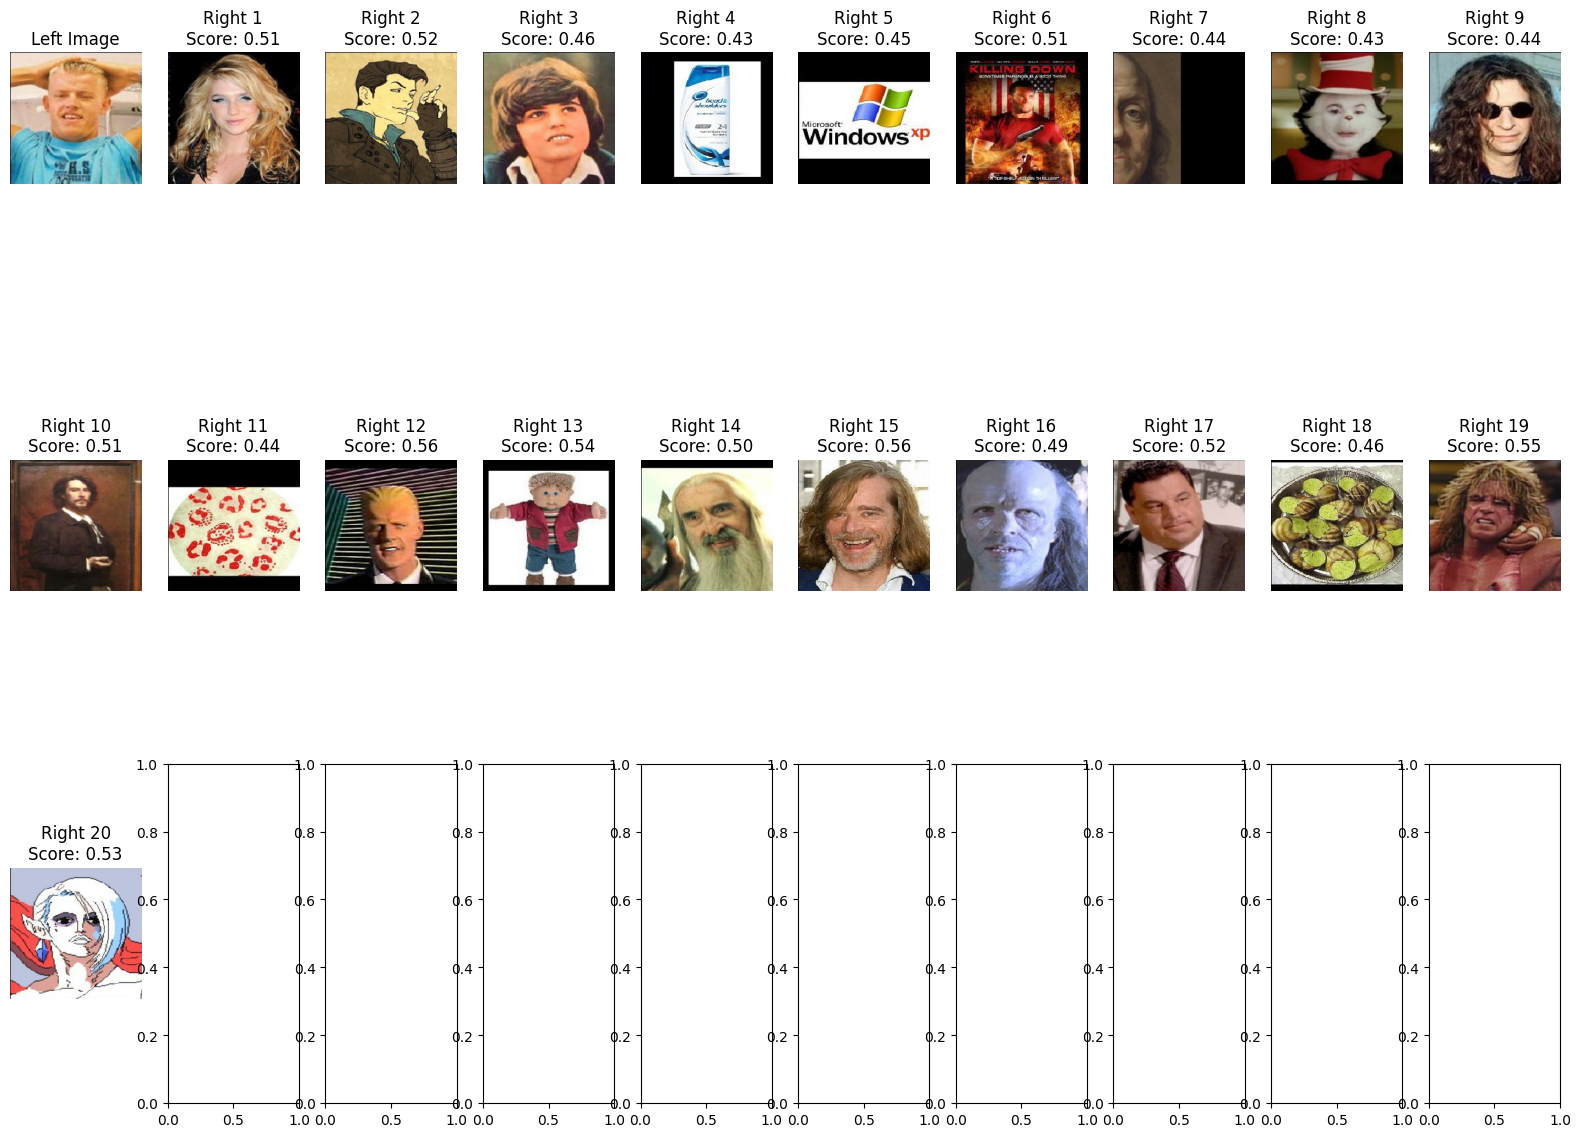

Row 1
  Column left: aci
  Column c0: jzn
  Column c1: hxw
  Column c2: iaj
  Column c3: edq
  Column c4: huu
  Column c5: huk
  Column c6: owo
  Column c7: ntd
  Column c8: uhk
  Column c9: ojv
  Column c10: mhg
  Column c11: exb
  Column c12: pny
  Column c13: kbo
  Column c14: tdb
  Column c15: sok
  Column c16: zsq
  Column c17: yfg
  Column c18: iqx
  Column c19: jnj
Similarity Scores: [0.4888717  0.48948357 0.554953   0.4584544  0.47296825 0.52937204
 0.5339689  0.5183756  0.3627956  0.63472366 0.5143507  0.41945148
 0.6141478  0.5371755  0.52377206 0.6319799  0.5018909  0.43733886
 0.38917    0.49610576]


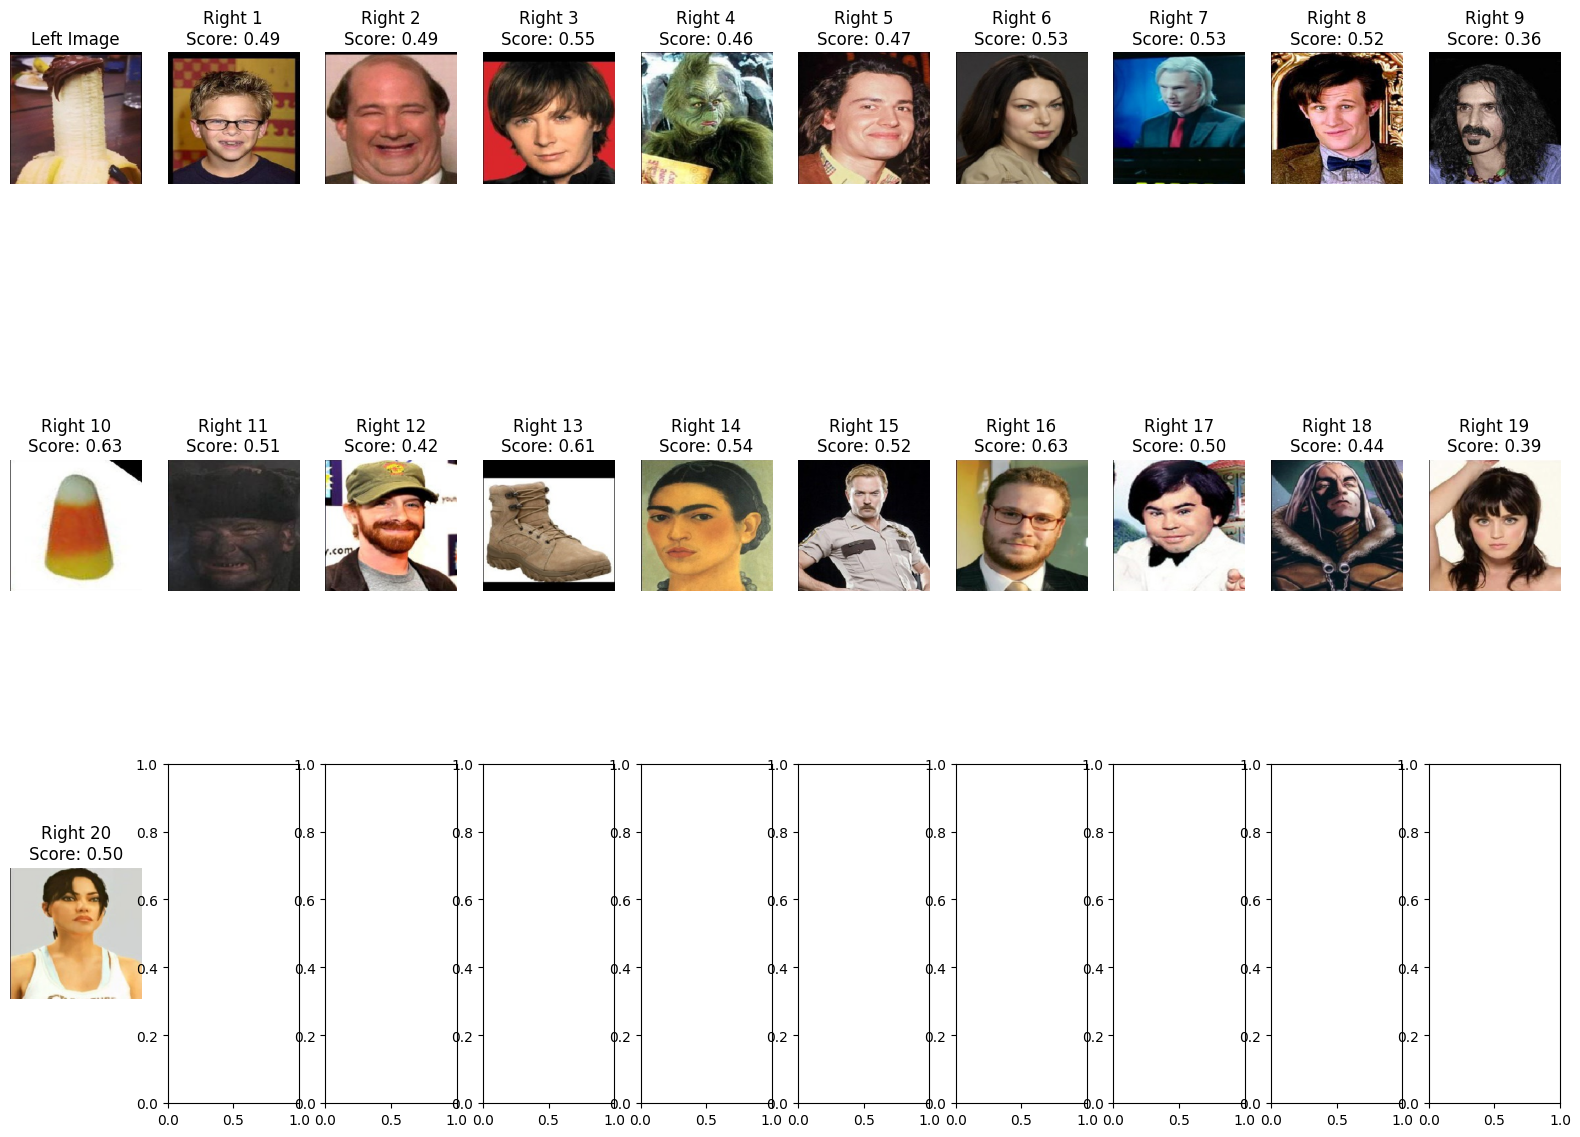

Row 2
  Column left: acn
  Column c0: ksm
  Column c1: tyj
  Column c2: hhy
  Column c3: rph
  Column c4: axt
  Column c5: dby
  Column c6: xiv
  Column c7: aoc
  Column c8: oxb
  Column c9: iyw
  Column c10: vsu
  Column c11: wrx
  Column c12: zem
  Column c13: rkq
  Column c14: vjq
  Column c15: duq
  Column c16: ncp
  Column c17: mst
  Column c18: wzd
  Column c19: gup
Similarity Scores: [0.51379704 0.5733634  0.42631924 0.57259065 0.5437602  0.63450986
 0.60155773 0.40199572 0.39901713 0.4466485  0.4478358  0.4893573
 0.48307487 0.4625613  0.37174883 0.40952262 0.45470545 0.51482916
 0.5710317  0.5755433 ]


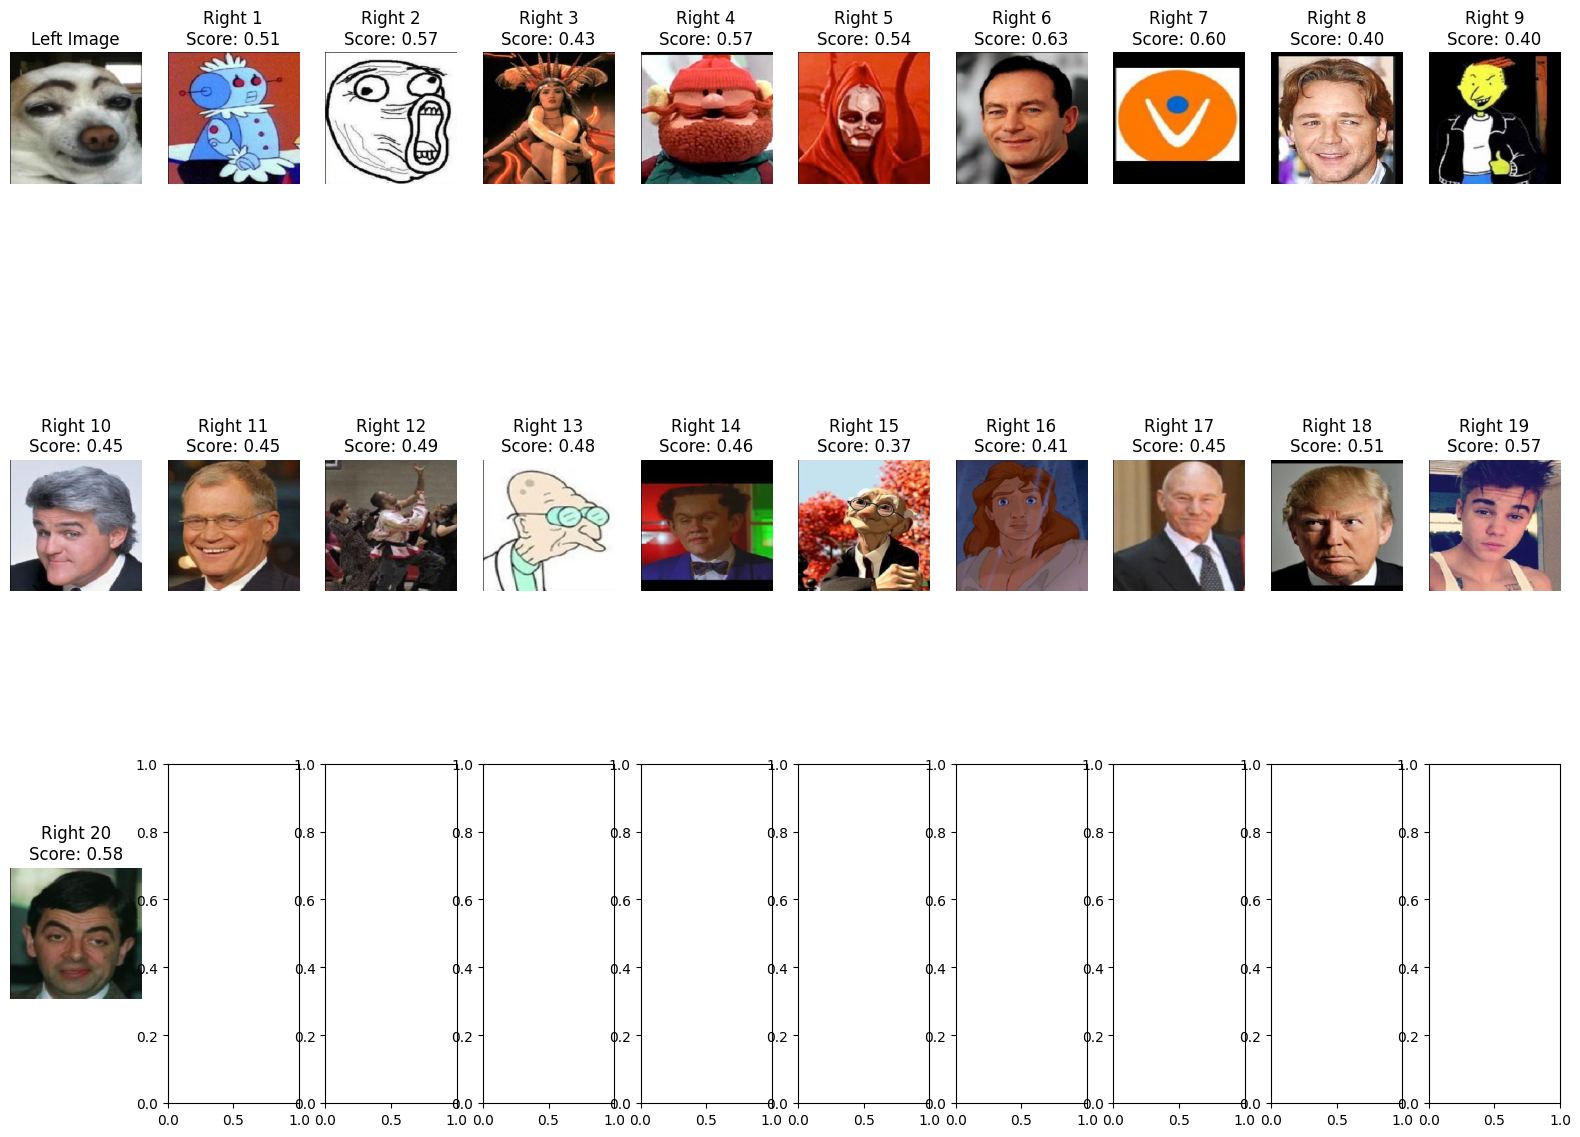

Row 3
  Column left: aco
  Column c0: tft
  Column c1: bxn
  Column c2: vkl
  Column c3: mdq
  Column c4: iqb
  Column c5: uev
  Column c6: mjn
  Column c7: ccy
  Column c8: nje
  Column c9: jsj
  Column c10: flo
  Column c11: ltz
  Column c12: sjz
  Column c13: ind
  Column c14: fbw
  Column c15: ahy
  Column c16: vwe
  Column c17: cog
  Column c18: xcj
  Column c19: boz
Similarity Scores: [0.46700323 0.44093916 0.39998293 0.66405284 0.5731411  0.6527755
 0.47790504 0.6749503  0.5059948  0.549733   0.45865443 0.39671594
 0.3448686  0.44980028 0.40017885 0.5059873  0.5574088  0.54266316
 0.4805408  0.48531216]


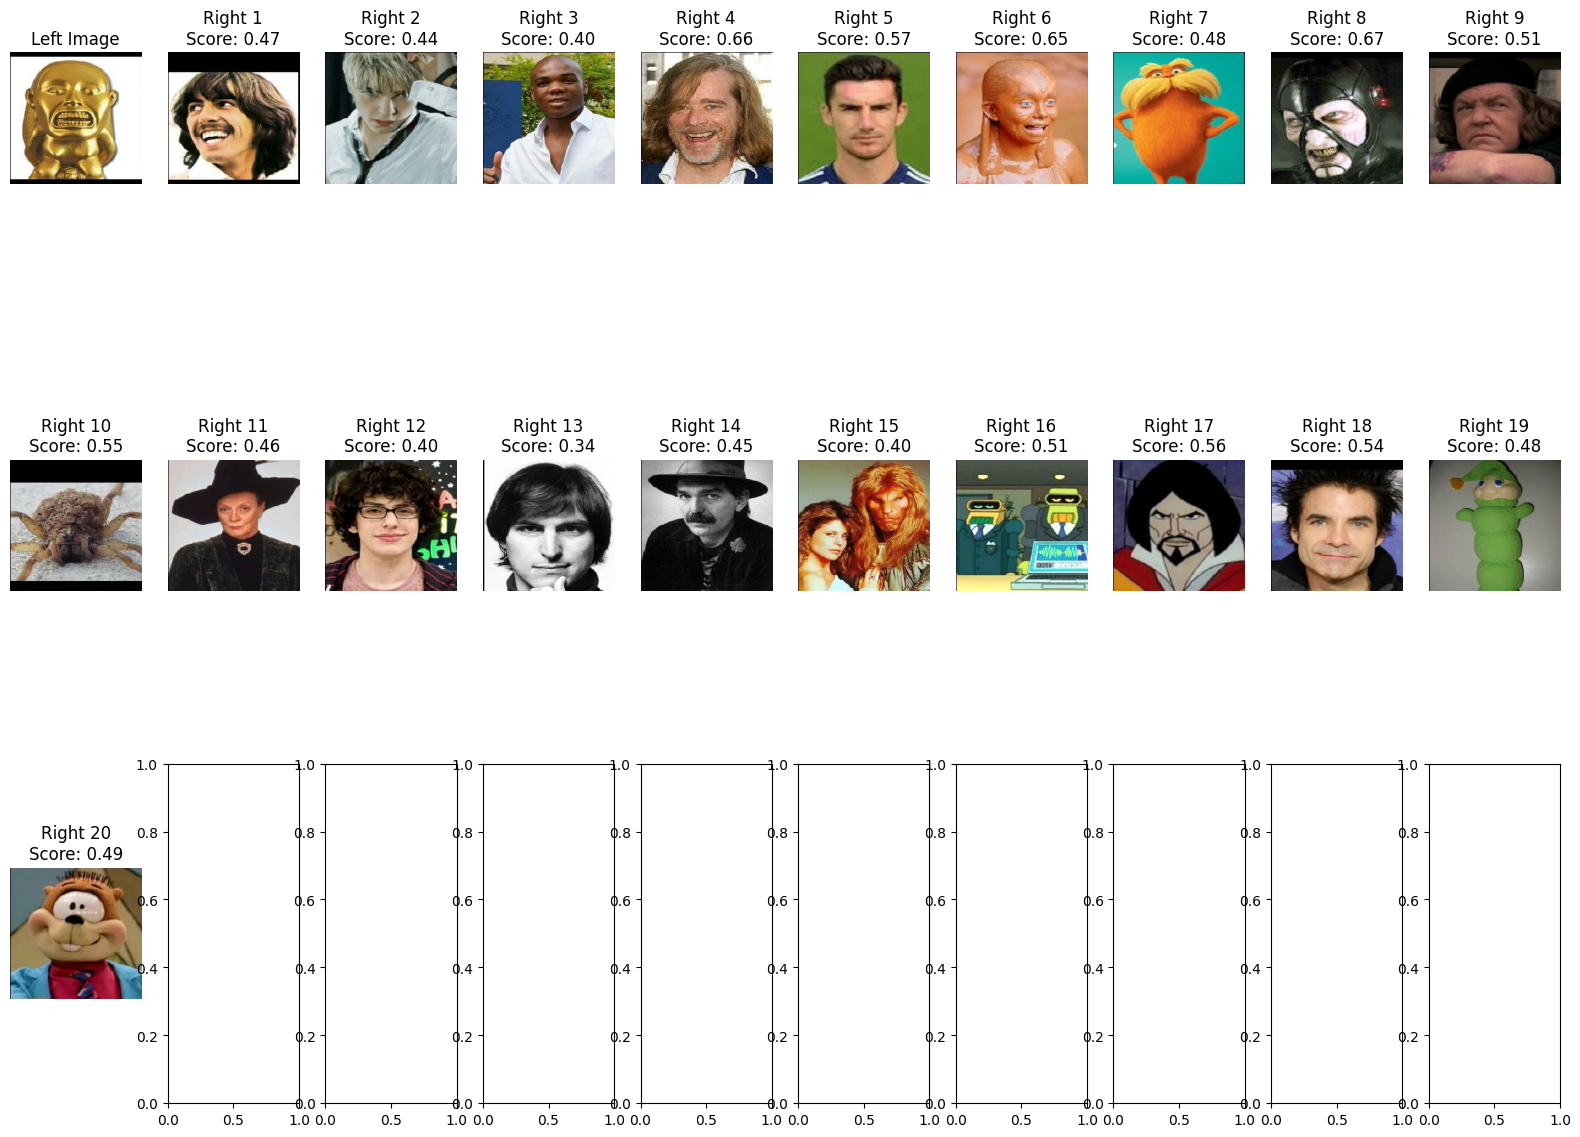

Row 4
  Column left: acu
  Column c0: apn
  Column c1: zip
  Column c2: cxx
  Column c3: cwh
  Column c4: wbu
  Column c5: azy
  Column c6: qoe
  Column c7: wnd
  Column c8: xoo
  Column c9: oxh
  Column c10: zwq
  Column c11: rqi
  Column c12: rei
  Column c13: poj
  Column c14: gos
  Column c15: hif
  Column c16: ami
  Column c17: fhc
  Column c18: ift
  Column c19: xcj
Similarity Scores: [0.56534225 0.65382737 0.6037767  0.4960735  0.64932555 0.43478426
 0.3783621  0.6387361  0.45048347 0.56753683 0.6821383  0.5366657
 0.5691792  0.4918376  0.4283022  0.45586768 0.5629523  0.6504248
 0.71218884 0.49213073]


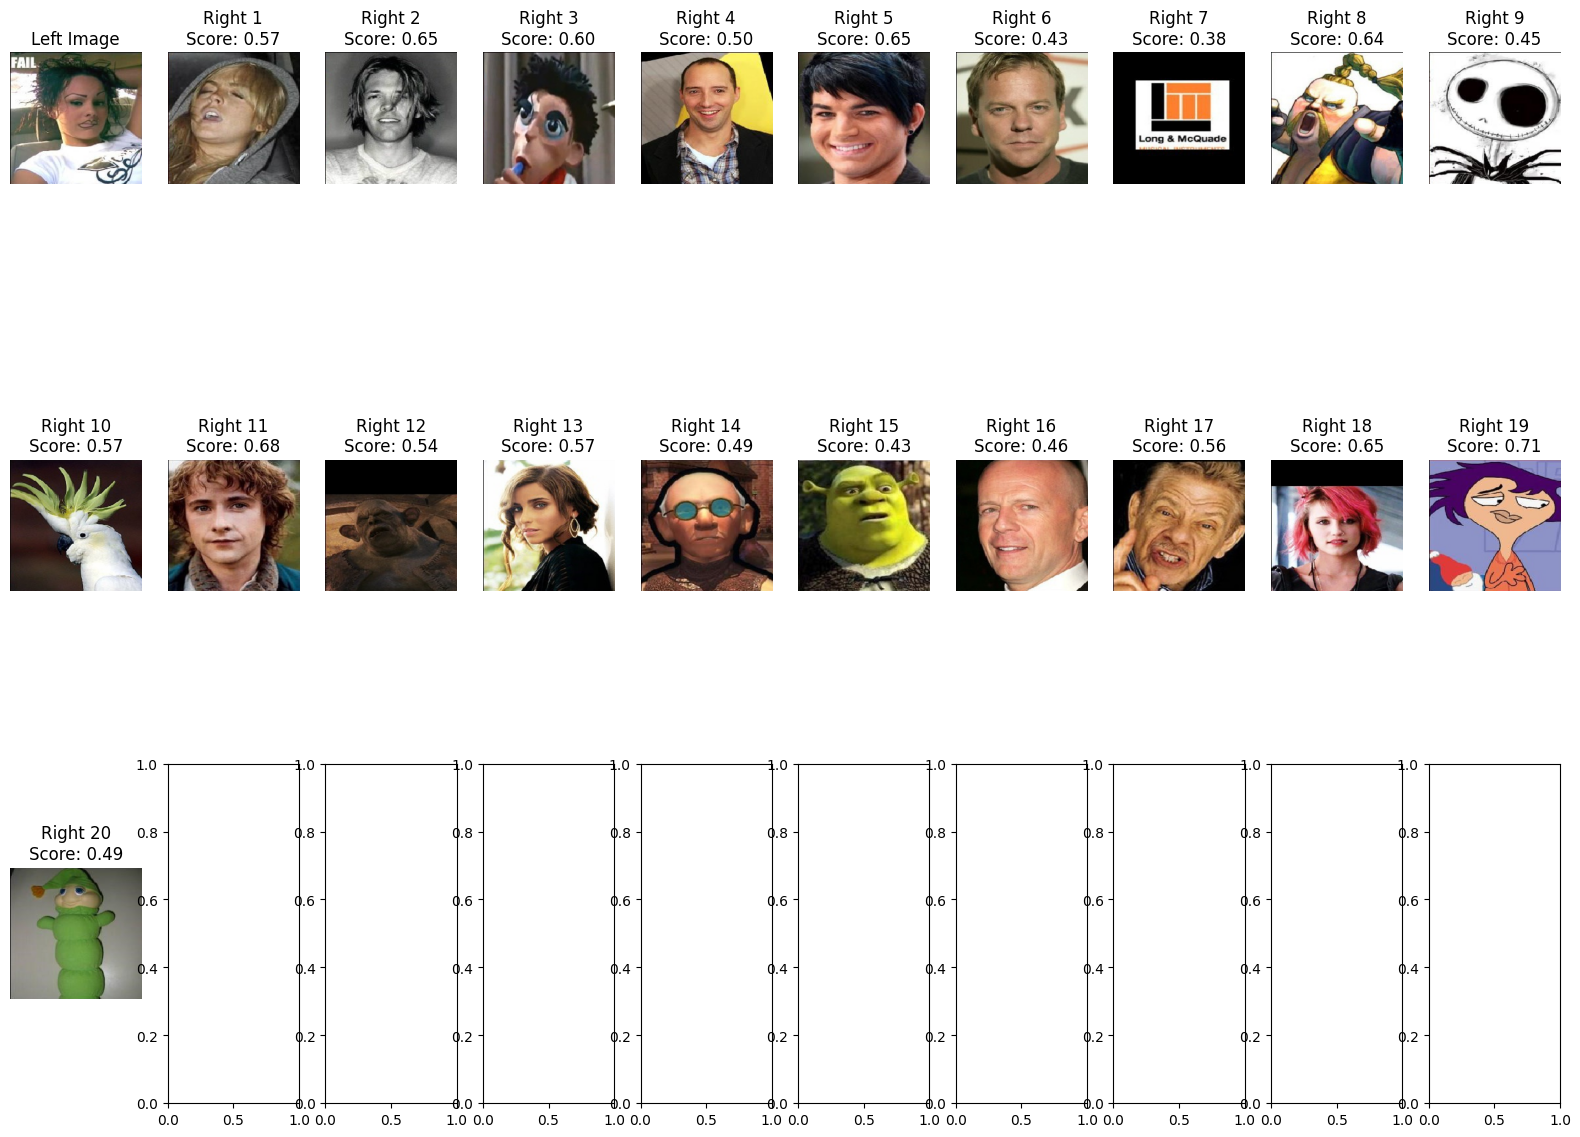

In [ ]:
show_test_case(siamese_model, test_candidates_df, row_number=5)